# Actividad 3.1 - Detección de Peatones con SVM

## Importado de librerías

In [1]:
import glob
import os
import tarfile

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from skimage.feature import hog
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearnex import patch_sklearn

# Aplicar patches a sklearn para mejorar performance.
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
random_state = np.random.RandomState(seed=42)

## Cargado de Dataset

El dataset fue obtenido de: http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Class__Bench/daimler_mono_ped__class__bench.html

Ya que el dataset viene en formato .tar.gz, la siguiente función hace la descarga directo desde la URL y extrae las imágenes en la carpeta indicada

In [3]:
def download_and_extract_dataset(url: str, target_dir: str):
    """
    Descarga y extrae un conjunto de datos en formato tar.gz desde una URL en el directorio especificado.

    Args:
        url (str): La URL de donde se descargará el conjunto de datos.
        target_dir (str): El directorio donde se guardará el conjunto de datos.
    """
    # Revisar que el directorio objetivo existe
    os.makedirs(target_dir, exist_ok=True)

    # Establece la ruta donde se guardará el conjunto de datos
    filename = url.split("/")[-1]
    file_path = os.path.join(target_dir, filename)

    # Verifica si el archivo ya existe
    if not os.path.exists(file_path):
        print("Descargando el conjunto de datos...")
        # Envía una solicitud GET a la URL
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            # Guarda el archivo en fragmentos para evitar usar demasiada memoria
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Descarga completa. Extrayendo archivos...")
            # Extrae el archivo tar.gz
            with tarfile.open(file_path, "r:gz") as tar:
                tar.extractall(path=target_dir)
            print("Extracción completa.")
        else:
            print("Fallo al descargar el archivo. Código de estado:", response.status_code)
    else:
        print("El conjunto de datos ya existe.")

In [4]:
dataset_url = "http://www.lookingatpeople.com/data/Daimler/pami06-munder-gavrila/DC-ped-dataset_base.tar.gz"
dataset_target_dir = "data/pedestrians"

download_and_extract_dataset(dataset_url, dataset_target_dir)

El conjunto de datos ya existe.


## Datos de Entrenamiento y Prueba

De acuerdo a la descripción del dataset que viene en la siguiente página: http://www.lookingatpeople.com/data/Daimler/pami06-munder-gavrila/README_benchmark.txt, el dataset tiene la siguiente estructura:

$$
\begin{table}
\begin{tabular}{|c|c|c|c|c|c|}
\hline
\textbf{Dataset Name} & \textbf{Purpose} & \textbf{Pedestrian Labels} & \textbf{Pedestrian Examples} & \textbf{Non-ped. Examples} & \textbf{Storage Size} \\ \hline
1                     & Training         & 800                         & 4800                         & 5000                        & 39 MB                 \\ \hline
2                     & Training         & 800                         & 4800                         & 5000                        & 39 MB                 \\ \hline
3                     & Training         & 800                         & 4800                         & 5000                        & 39 MB                 \\ \hline
T1                    & Test             & 800                         & 4800                         & 5000                        & 39 MB                 \\ \hline
T2                    & Test             & 800                         & 4800                         & 5000                        & 39 MB                 \\ \hline
\end{tabular}
\end{table}
$$

In [5]:
def get_data_files(sub_dir: str, sub_dirs: str, file_extension: str='pgm') -> list:
    data = []
    for sub_dir in sub_dirs:
        data_files = glob.glob(f"{dataset_target_dir}/{sub_dir}/*.{file_extension}")
        data.extend(data_files)
    return data
    

Datos de entrenamiento

In [6]:
train_pedestrians_sub_dirs = ["1/ped_examples", "2/ped_examples", "3/ped_examples"]
train_pedestrians = get_data_files(dataset_target_dir, train_pedestrians_sub_dirs)
len(train_pedestrians)

14400

In [7]:
train_non_pedestrians_sub_dirs = ["1/non-ped_examples", "2/non-ped_examples", "3/non-ped_examples"]
train_non_pedestrians = get_data_files(dataset_target_dir, train_non_pedestrians_sub_dirs)
len(train_non_pedestrians)

15000

Datos de prueba

In [8]:
test_pedestrians_sub_dirs = ["T1/ped_examples", "T2/ped_examples"]
test_pedestrians = get_data_files(dataset_target_dir, test_pedestrians_sub_dirs)
len(test_pedestrians)

9600

In [9]:
test_non_pedestrians_sub_dirs = ["T1/non-ped_examples", "T2/non-ped_examples"]
test_non_pedestrians = get_data_files(dataset_target_dir, test_non_pedestrians_sub_dirs)
len(test_non_pedestrians)

10000

## Cálculo de HOG en una sola imagen

Visualización de la imagen de un solo peatón

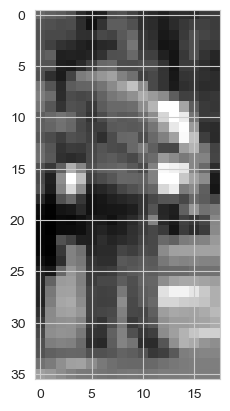

In [10]:
img_pedestrian = cv2.imread(train_pedestrians[150], cv2.COLOR_BGR2GRAY)
plt.imshow(img_pedestrian, cmap='gray')
plt.show()

In [11]:
print(img_pedestrian.shape)

(36, 18)


In [12]:
features, hog_image = hog(img_pedestrian, 
                          orientations=10, 
                          pixels_per_cell=(6, 6),
                          cells_per_block=(2, 2), 
                          transform_sqrt= False,
                          visualize=True,
                          feature_vector=True)

In [13]:
print(features.shape)

(400,)


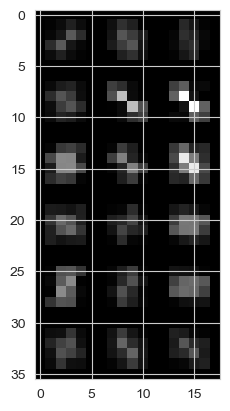

In [14]:
plt.imshow(hog_image, cmap='gray')
plt.show()

## Extracción las features HOG para los datos

In [15]:
def extract_hog_features(img_data_list: list) -> list:
    hog_data = list()
    for img_data in img_data_list:
        img = cv2.imread(img_data, cv2.COLOR_BGR2GRAY)
        img_hog_feature, img_hog_image = hog(img,
                                             orientations=10, 
                                             pixels_per_cell=(6, 6),
                                             cells_per_block=(2, 2), 
                                             transform_sqrt= False,
                                             visualize=True,
                                             feature_vector=True)
        hog_data.append(img_hog_feature)
    
    return hog_data

In [16]:
X_train_pedestrians = np.vstack(extract_hog_features(train_pedestrians)).astype(np.float32)
y_train_pedestrians = np.ones(len(X_train_pedestrians))

X_train_non_pedestrians = np.vstack(extract_hog_features(train_non_pedestrians)).astype(np.float32)
y_train_non_pedestrians = np.zeros(len(X_train_non_pedestrians))

X_train = np.vstack((X_train_pedestrians, X_train_non_pedestrians))
y_train = np.hstack((y_train_pedestrians, y_train_non_pedestrians))

# Poner datos de forma aleatoria
indices = random_state.permutation(len(X_train))
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]

In [17]:
del X_train
del y_train
del train_pedestrians
del train_non_pedestrians

In [18]:
X_test_pedestrians = np.vstack(extract_hog_features(test_pedestrians)).astype(np.float32)
y_test_pedestrians = np.ones(len(X_test_pedestrians))

X_test_non_pedestrians = np.vstack(extract_hog_features(test_non_pedestrians)).astype(np.float32)
y_test_non_pedestrians = np.zeros(len(X_test_non_pedestrians))

X_test = np.vstack((X_test_pedestrians, X_test_non_pedestrians))
y_test = np.hstack((y_test_pedestrians, y_test_non_pedestrians))

# Poner datos de forma aleatoria
indices = random_state.permutation(len(X_test))
X_test_shuffled = X_test[indices]
y_test_shuffled = y_test[indices]

In [19]:
del X_test
del y_test
del test_pedestrians
del test_non_pedestrians

## Modelo SVM y entrenamiento

In [20]:
svc_model = SVC()
svc_model.fit(X_train_shuffled, y_train_shuffled)

SVC()

In [21]:
y_pred = svc_model.predict(X_test_shuffled)

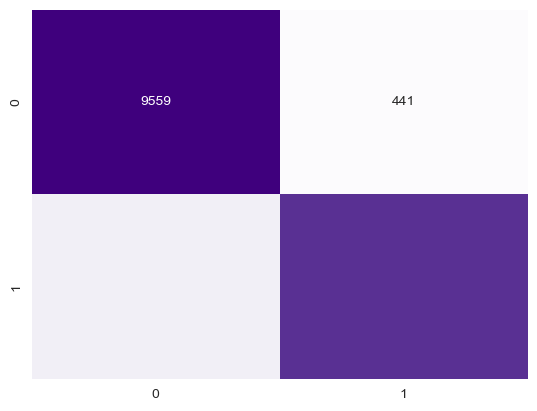

In [22]:
cm = confusion_matrix(y_test_shuffled, y_pred, labels=[0, 1])
sns.heatmap(cm,  annot=True, fmt='g', cmap='Purples', cbar=False) 
plt.show()

In [23]:
print(cm)

[[9559  441]
 [1464 8136]]


In [24]:
print(classification_report(y_test_shuffled, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     10000
         1.0       0.95      0.85      0.90      9600

    accuracy                           0.90     19600
   macro avg       0.91      0.90      0.90     19600
weighted avg       0.91      0.90      0.90     19600



## Grid Search

In [25]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']}

In [26]:
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)
grid_search.fit(X_train_shuffled, y_train_shuffled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.554 total time= 3.7min
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.550 total time= 3.7min
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.554 total time= 3.7min
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.550 total time= 3.6min
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.548 total time= 3.6min
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.864 total time= 2.7min
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.855 total time= 2.7min
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.848 total time= 2.7min
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.856 total time= 2.7min
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.853 total time= 2.7min
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.896 total time= 1.7min
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             verbose=4)

In [27]:
grid_search.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [28]:
grid_search.best_estimator_

SVC(C=100, gamma=0.1)

In [29]:
grid_predictions = grid_search.predict(X_test_shuffled)

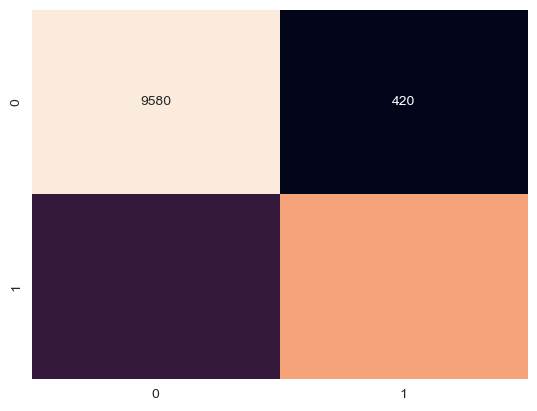

In [31]:
cm = confusion_matrix(y_test_shuffled, grid_predictions)
sns.heatmap(cm, annot=True, fmt='g', cbar=False) 
plt.show()

In [32]:
cm

array([[9580,  420],
       [1708, 7892]], dtype=int64)

In [33]:
print(classification_report(y_test_shuffled, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     10000
         1.0       0.95      0.82      0.88      9600

    accuracy                           0.89     19600
   macro avg       0.90      0.89      0.89     19600
weighted avg       0.90      0.89      0.89     19600

